In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import datetime

### file hierarchy and database connection vars

In [2]:
## directory & file hierarchy
iterationName = 'CDM_photodraw_e1'
exp_path = 'photodraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches_CDM_included_only')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)

## dir where we can keep all sketches not binned by category    

In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db['CDM_photodraw_e1']


### Preprocessing data and rendering images

Notes:
There are two types of records in the database: 'stroke' and 'finalImage'. This is stored under the key: 'dataType'.
The 'stroke'-type of record contains the svg string information. Every stroke event is stored as a separate record.
The session identifier is called "sessionId".




In [31]:
total_sessions = coll.find().distinct('sessionId') ## this returns ALL sessions in this collection.
print 'We currently have {} total sessions.'.format(len(total_sessions))

We currently have 87 total sessions.


In [32]:
## see  https://docs.google.com/spreadsheets/d/1pZ2MFfAjoT_11ZJQcSAjdeA_ZZvRraTZRqkVBcVIXCM/edit#gid=8551646
## for information on which 
exclude_session_id=['CDM_photodraw_e11532109648493',
'CDM_photodraw_e11532110198274',
'CDM_photodraw_e11532119534231',
'CDM_photodraw_e11532120540660',
'CDM_photodraw_e11532121593015',
'CDM_photodraw_e11532123507785',
'CDM_photodraw_e11532454335609',
'CDM_photodraw_e11532455751579',
'CDM_photodraw_e11532455837908',
'CDM_photodraw_e11532463418268',
'CDM_photodraw_e11532468803382',
'CDM_photodraw_e11532472054977',
'CDM_photodraw_e11532540831557',
'CDM_photodraw_e11532543365329',
'CDM_photodraw_e11532551867786',
'CDM_photodraw_e11532556255130',
'CDM_photodraw_e11532558764161',
'CDM_photodraw_e11533073503103',
'CDM_photodraw_e11533144107489',
'CDM_photodraw_e11533147048549',
'CDM_photodraw_e11532463825380',
'CDM_photodraw_e11532461805013',
'CDM_photodraw_e11532541701592']

In [37]:
really_run_this = 1
if really_run_this:
    ## img writing parameters
    imsize = 224
    
    ## desired output: a dataframe that has trials on the rows, and the following columns:
    ## category, age, number of strokes, mean_pixel_intensity, bounding_box_coordinates_LTRB, list of strokes, 
    ## PNG string, submission_time, submission_date
    ## to be saved out as a nice tidy CSV
    session_id = []
    trial_num = []
    category = []
    num_strokes = []
    mean_pixel_intensity = []
    bounding_box_coords = []
    svg = []
    kidName = []
    svg_times = []
    png = []
    submit_time = []
    submit_date = []
    draw_duration = []
    filename = []
    age=[]
    countErr = 0
    condition=[]
    S_num_stroke=[]
    W_num_stroke=[]
    P_num_stroke=[]
    S_time=[]
    W_time=[]
    P_time=[]
    readadble_date = []
    exclude_category = ['this circle','this square','this shape']
    exclude_age = ['age8','age9','age10']
    for s in valid_sessions:
        this_collection = coll
        image_recs = this_collection.find({'$and': [{'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
        for imrec in image_recs:  
                ## if you want to render all sessions
                # if imrec['category'] not in exclude_category:
                
                ## exclude invalid sessions, tracing trials, and old kids just in case our filtering didn't get them.
                if imrec['sessionId'] not in exclude_session_id and imrec['category'] not in exclude_category and imrec['age'] not in exclude_age:
                    stroke_recs = this_collection.find({'$and': [ 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')   

                    if stroke_recs.count() > 0: ## only include trials if the drawings are not blank            
                        session_id.append(imrec['sessionId'])        
                        trial_num.append(imrec['trialNum']) 
                        category.append(imrec['category'])


                        try:    
                            png.append(imrec['imgData'])
                            submit_time.append(imrec['time'])
                            submit_date.append(imrec['date'])
                            age.append(imrec['age'])
                            condition.append(imrec['condition'])
                            filename.append(os.path.join(sketch_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'], imrec['sessionId'], imrec['condition'], imrec['age'])))
                            num_strokes.append(stroke_recs.count())

                            _svg = [] # this keeps track of the strokes from THIS final image
                            _svg_times = []
                            for strec in stroke_recs:
                                _svg.append(strec['svg'])
                                _svg_times.append(strec['time'])
                            draw_duration.append((_svg_times[-1] - _svg_times[0])/1000) ## in seconds
                            svg.append(_svg)
                            svg_times.append(_svg_times)

                            if imrec['condition']=='S':
                                S_num_stroke.append(stroke_recs.count())
                                S_time.append((_svg_times[-1] - _svg_times[0])/1000)
                            elif imrec['condition']=='W':
                                W_num_stroke.append(stroke_recs.count())
                                W_time.append((_svg_times[-1] - _svg_times[0])/1000)
                            elif imrec['condition']=='P':
                                P_num_stroke.append(stroke_recs.count())
                                P_time.append((_svg_times[-1] - _svg_times[0])/1000)

                            ## and write out image data here too
                            imgData = imrec['imgData'];
                            filestr = base64.b64decode(imgData)
                            child_dir = os.path.join(sketch_dir,imrec['condition'],imrec['age'],imrec['sessionId'])
                            if not os.path.exists(child_dir):
                                os.makedirs(child_dir)
                            fname = os.path.join(child_dir,'{}_sketch_{}_{}_{}.png'.format(imrec['category'],imrec['sessionId'],imrec['condition'], imrec['age']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                        except:
                            print('something went wrong with an image')
                            countErr = countErr + 1
                            print imrec['category']
                            child_dir = os.path.join(sketch_dir,'noname')
                            if not os.path.exists(child_dir):
                                os.makedirs(child_dir)
                            fname = os.path.join(child_dir,'{}_sketch_{}_{}.png'.format(imrec['category'], 'noname',imrec['sessionId']))
                            with open(fname, "wb") as fh:
                                fh.write(imgData.decode('base64'))  
                        

In [26]:
## How many session IDs do we have?
np.size(np.unique(session_id))

## How many session IDs do we have?
condition.count("W")
##
condition.count("S")
##
condition.count("P")

90

In [20]:
if really_run_this:
    X = pd.DataFrame([session_id,age,trial_num,condition,category,submit_time,submit_date,num_strokes,svg,svg_times,png,draw_duration,filename])
    X = X.transpose()
    X.columns = ['session_id','age','trial_num','condition','category','submit_time','submit_date','num_strokes','svg','svg_times','png','draw_duration', 'filename']
X.to_csv("photodraw_data_Aug1.csv")


### Basic visualizations of stroke numbers and time spent

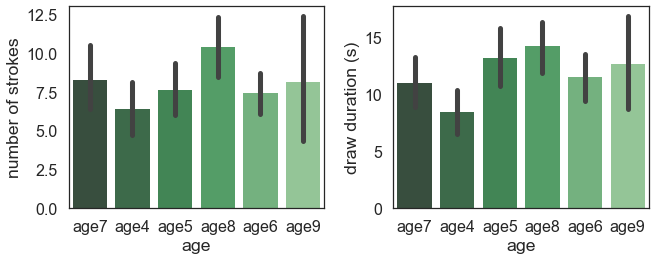

In [68]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='age',y='num_strokes', palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='age',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.tight_layout()

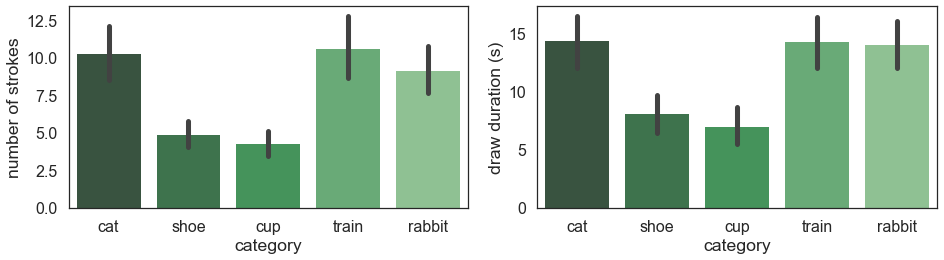

In [69]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='category',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='category',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

# plt.subplot(1,3,3)
# seq = np.arange(4,10)
# sns.barplot(data=X,x='age',y='mean_intensity',order=seq,palette="Greens_d")
# plt.ylabel('mean pixel intensity')

plt.tight_layout()

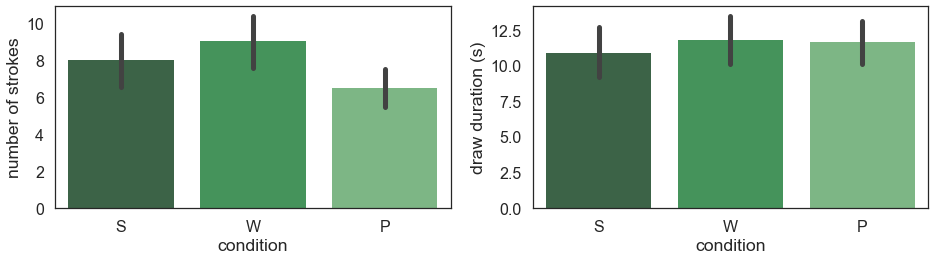

In [81]:
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
seq = np.arange(4,10)
sns.barplot(data=X,x='condition',y='num_strokes',palette="Greens_d")
plt.ylabel('number of strokes')

plt.subplot(1,3,2)
seq = np.arange(4,10)

sns.barplot(data=X,x='condition',y='draw_duration', palette="Greens_d")
plt.ylabel('draw duration (s)')

plt.tight_layout()

In [ ]:
# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i  in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat



# categories = [i for i in os.listdir('sketches') if i != '.DS_Store']
# num_ims = 0
# ims_per_cat = []
# for c in categories:
#     num_ims += len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store'])
#     ims_per_cat.append(len([i for i in os.listdir(os.path.join('sketches',c)) if i != '.DS_Store']))
    
# print num_ims
# print ims_per_cat